In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Import the required libraries.
import os
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Dropout, Flatten, LSTM, Dense

In [3]:
seed_constant = 3
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [4]:
base_directory = '/content/drive/MyDrive/videos'

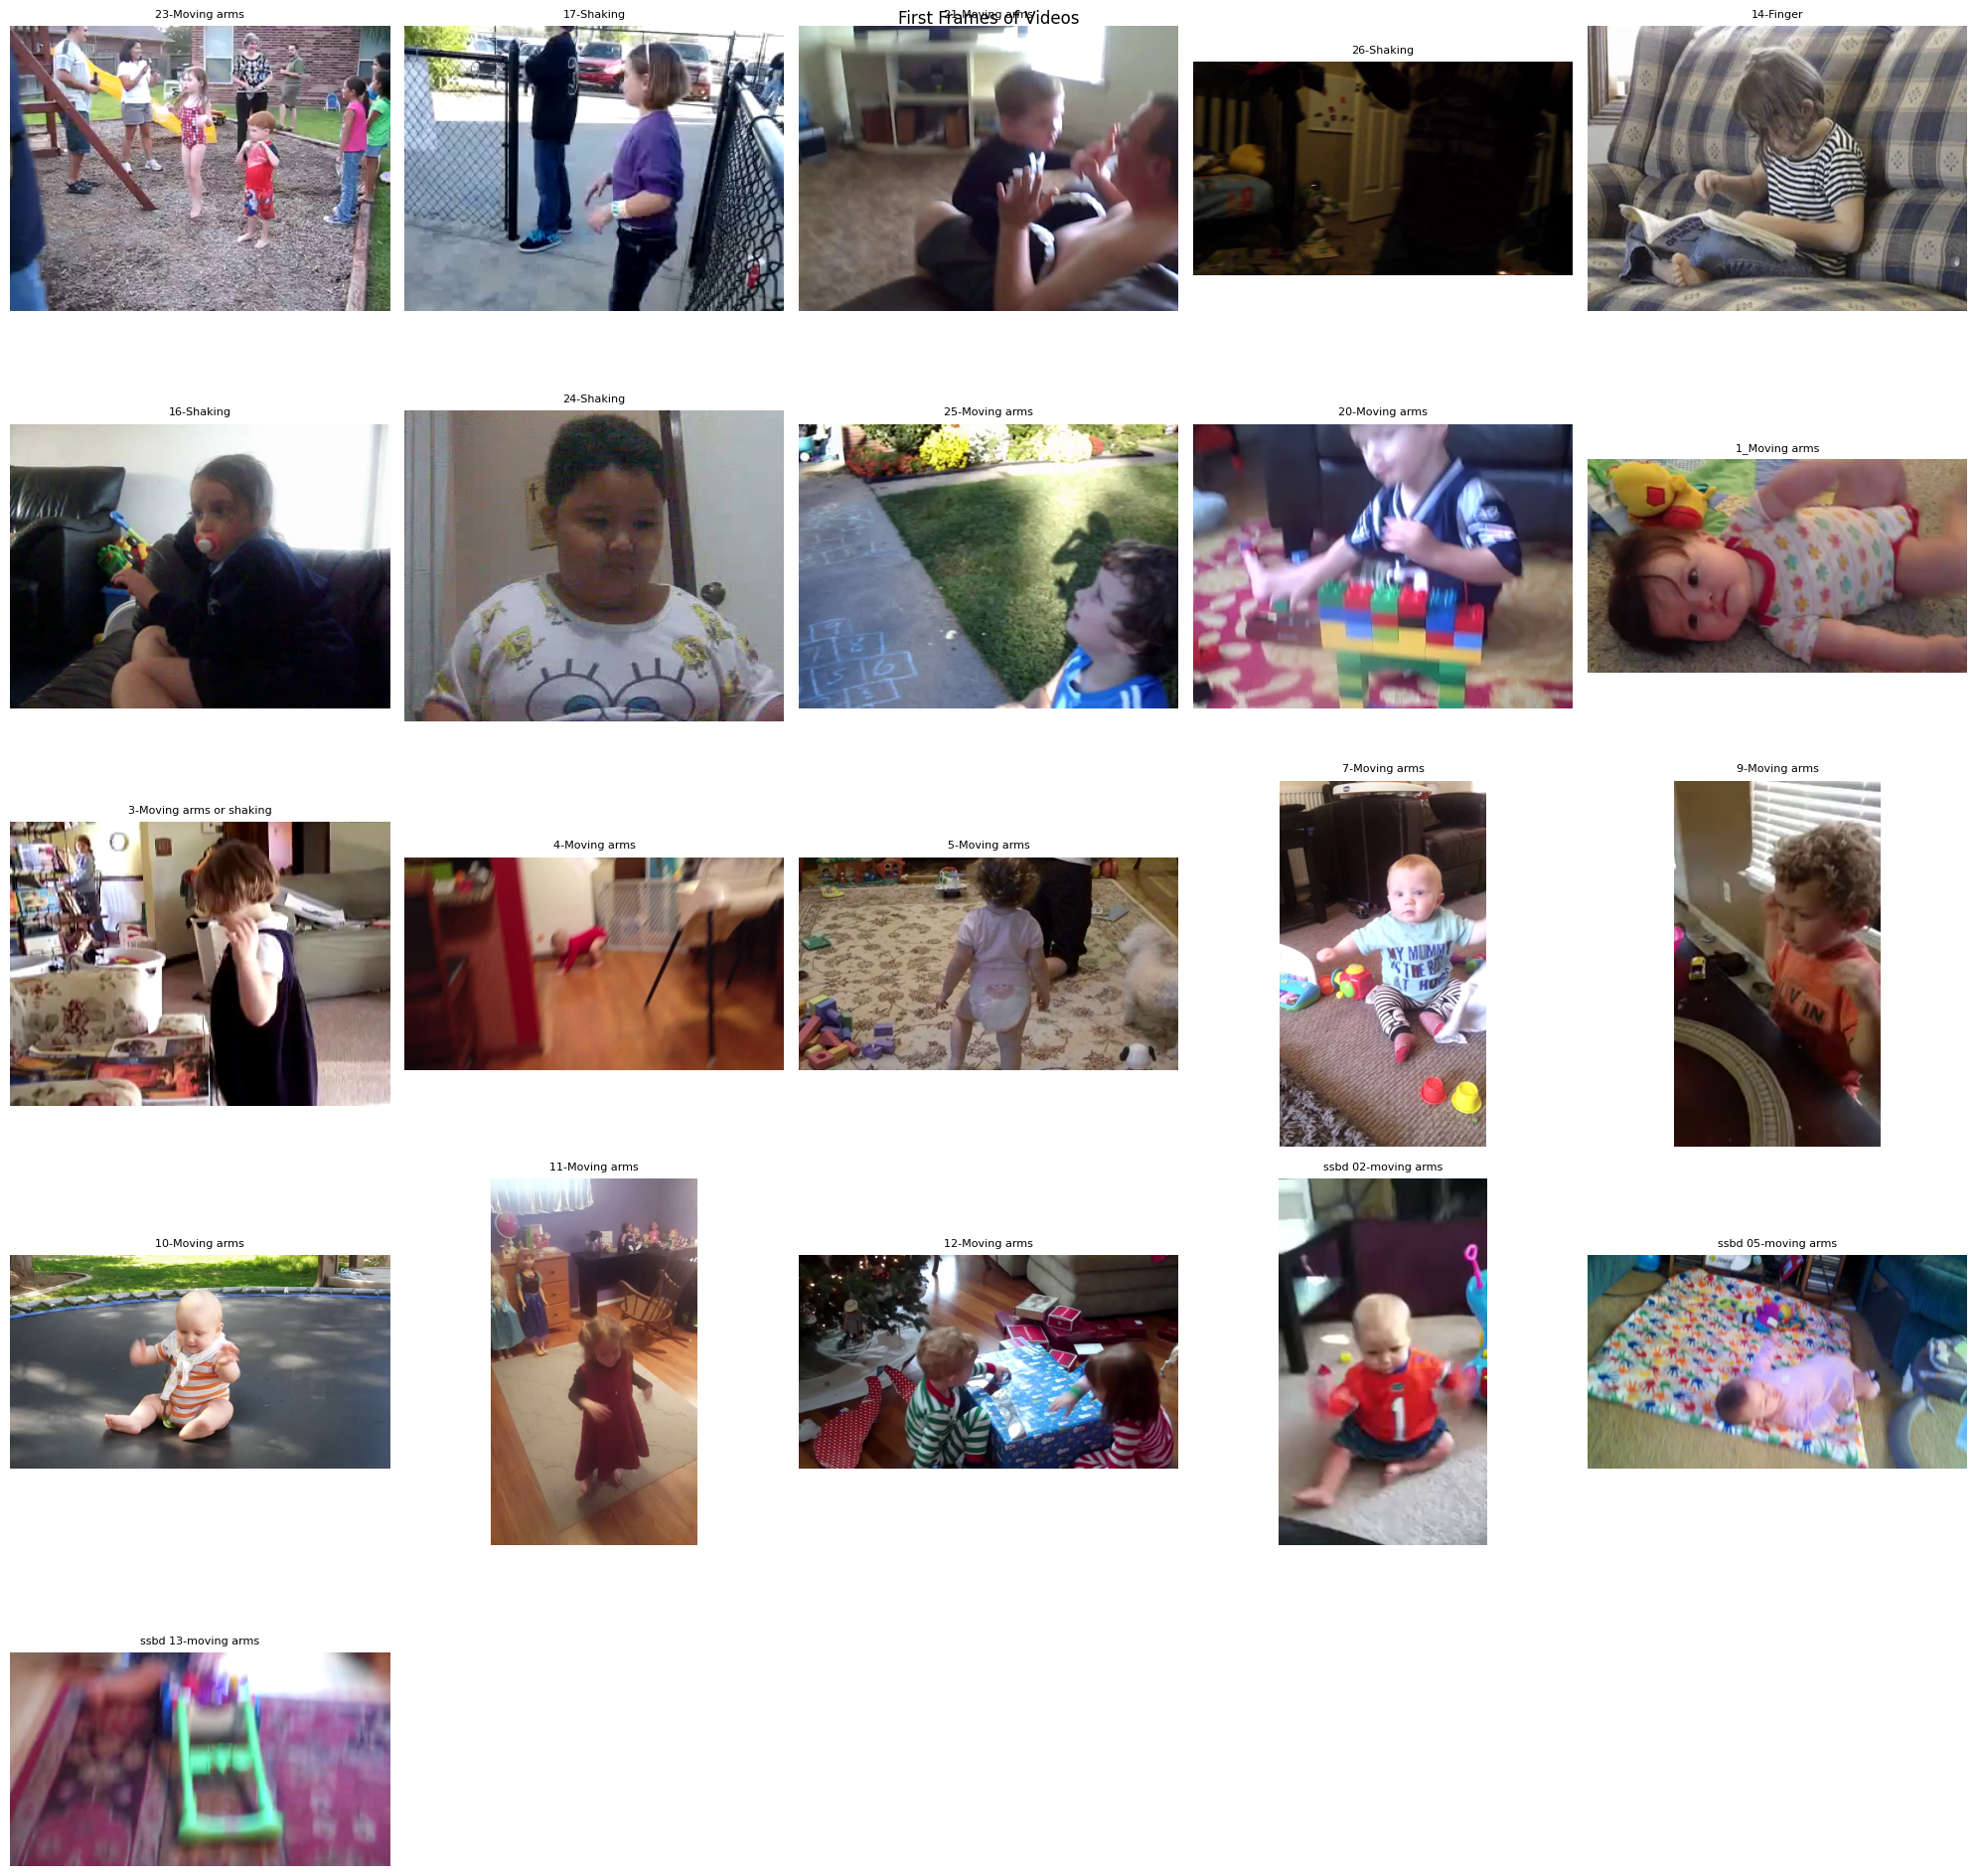

In [5]:
counter = 1
total_videos = 0

# Get the list of all files in the base_directory
all_files = [f for f in os.listdir(base_directory) if os.path.isfile(os.path.join(base_directory, f))]

video_files = [f for f in all_files if f.endswith(('.mp4', '.avi', '.mov'))]
total_videos = len(video_files)

# Calculate grid size for subplots
grid_size = int(total_videos**0.5) + 1  # Square root to determine grid dimensions
plt.figure(figsize=(20, 20))

# Process and display each video's first frame
for video in video_files:
    video_path = os.path.join(base_directory, video)
    video_reader = cv2.VideoCapture(video_path)

    if video_reader.isOpened():
        _, bgr_frame = video_reader.read()
        video_reader.release()

        if bgr_frame is not None:
            video_name = video.split('.')[0]
            rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
            plt.subplot(grid_size, grid_size, counter)
            plt.imshow(rgb_frame)
            plt.title(video_name, fontsize=8)
            plt.axis('off')
            counter += 1
        else:
            print(f"Failed to read frame from {video_path}")
    else:
        print(f"Failed to open video {video_path}")

plt.tight_layout()
plt.suptitle('First Frames of Videos')
plt.show()

In [6]:
video_files = []

# List all files in the base directory and add them to the video_files list if they are files
video_files = [os.path.join(base_directory, f) for f in os.listdir(base_directory) if os.path.isfile(os.path.join(base_directory, f))]

print(video_files)

['/content/drive/MyDrive/videos/23-Moving arms.mp4', '/content/drive/MyDrive/videos/17-Shaking.mp4', '/content/drive/MyDrive/videos/21-Moving arms.mp4', '/content/drive/MyDrive/videos/26-Shaking.mp4', '/content/drive/MyDrive/videos/14-Finger.mp4', '/content/drive/MyDrive/videos/16-Shaking.mp4', '/content/drive/MyDrive/videos/24-Shaking.mp4', '/content/drive/MyDrive/videos/25-Moving arms.mp4', '/content/drive/MyDrive/videos/20-Moving arms.mp4', '/content/drive/MyDrive/videos/1_Moving arms.mp4', '/content/drive/MyDrive/videos/3-Moving arms or shaking.mp4', '/content/drive/MyDrive/videos/4-Moving arms.mp4', '/content/drive/MyDrive/videos/5-Moving arms.mp4', '/content/drive/MyDrive/videos/7-Moving arms.mp4', '/content/drive/MyDrive/videos/9-Moving arms.mp4', '/content/drive/MyDrive/videos/10-Moving arms.mp4', '/content/drive/MyDrive/videos/11-Moving arms.mp4', '/content/drive/MyDrive/videos/12-Moving arms.mp4', '/content/drive/MyDrive/videos/ssbd 02-moving arms.mp4', '/content/drive/MyDriv

In [7]:
import cv2
import os

video_files = [os.path.join(base_directory, f) for f in os.listdir(base_directory) if os.path.isfile(os.path.join(base_directory, f))]

def get_video_fps(video_path):
    video = cv2.VideoCapture(video_path)
    fps = video.get(cv2.CAP_PROP_FPS)
    video.release()
    return fps

# Iterate through the list of video file paths and print their fps
for video_path in video_files:
    fps = get_video_fps(video_path)
    print(f"Video: {video_path}, FPS: {fps}")

Video: /content/drive/MyDrive/videos/23-Moving arms.mp4, FPS: 30.0
Video: /content/drive/MyDrive/videos/17-Shaking.mp4, FPS: 15.0
Video: /content/drive/MyDrive/videos/21-Moving arms.mp4, FPS: 30.0
Video: /content/drive/MyDrive/videos/26-Shaking.mp4, FPS: 29.97002997002997
Video: /content/drive/MyDrive/videos/14-Finger.mp4, FPS: 30.0
Video: /content/drive/MyDrive/videos/16-Shaking.mp4, FPS: 29.6752
Video: /content/drive/MyDrive/videos/24-Shaking.mp4, FPS: 14.767
Video: /content/drive/MyDrive/videos/25-Moving arms.mp4, FPS: 25.0
Video: /content/drive/MyDrive/videos/20-Moving arms.mp4, FPS: 30.0
Video: /content/drive/MyDrive/videos/1_Moving arms.mp4, FPS: 30.0
Video: /content/drive/MyDrive/videos/3-Moving arms or shaking.mp4, FPS: 23.954
Video: /content/drive/MyDrive/videos/4-Moving arms.mp4, FPS: 30.0
Video: /content/drive/MyDrive/videos/5-Moving arms.mp4, FPS: 29.97002997002997
Video: /content/drive/MyDrive/videos/7-Moving arms.mp4, FPS: 28.827674567584882
Video: /content/drive/MyDrive/

In [82]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 15

DATASET_DIR = '/content/drive/MyDrive/videos'

# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
CLASSES_LIST = ['moving_arms', 'hand_shaking', 'nothing']

In [83]:
def classify_frames(video_path, action_intervals, standard_fps=15, image_height=IMAGE_HEIGHT, image_width=IMAGE_WIDTH):
    def timestamp_to_frame(timestamp, standard_fps):
      parts = timestamp.split(':')
      if len(parts) == 2:
          # Format is MM:SS
          m, s = map(int, parts)
          total_seconds = m * 60 + s
      elif len(parts) == 3:
          # Format is HH:MM:SS
          h, m, s = map(int, parts)
          total_seconds = h * 3600 + m * 60 + s
      else:
          raise ValueError(f"Invalid timestamp format: {timestamp}")

      return int(total_seconds * standard_fps)

    video = cv2.VideoCapture(video_path)
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

    action_frames = {action: [] for action in action_intervals}
    action_frames['nothing'] = []

    for frame_num in range(total_frames):
      success, frame = video.read()
      if not success:
          break

      resized_frame = cv2.resize(frame, (image_height, image_width))
      normalized_frame = resized_frame / 255.0

      label = 'nothing'
      for action, intervals in action_intervals.items():
          for start_time, end_time in intervals:
              start_frame = timestamp_to_frame(start_time, standard_fps)
              end_frame = timestamp_to_frame(end_time, standard_fps)
              if start_frame <= frame_num <= end_frame:
                  label = action
                  break
          if label != 'nothing':
              break

      action_frames[label].append(normalized_frame)

    video.release()
    return action_frames

In [84]:
video_timestamps = {
    '/content/drive/MyDrive/videos/10-Moving arms.mp4': {
        'moving_arms': [('00:00', '00:03'),
                        ('00:03', '00:05'),
                        ('00:16', '00:19'),
                        ('00:21', '00:23'),
                        ('00:25', '00:27'),
                        ('00:30', '00:32'),
                        ('00:39', '00:43'),
                        ('01:01', '01:02'),
                        ('01:09', '01:13'),
                        ('01:14', '01:16'),
                        ('01:30', '01:32'),
                        ('01:39', '01:41')]
    },
    '/content/drive/MyDrive/videos/11-Moving arms.mp4':{
        'hand_shaking':[('00:00', '00:02')]
    },
    '/content/drive/MyDrive/videos/12-Moving arms.mp4':{
        'hand_shaking':[('00:07', '00:09'), ('00:14', '00:19'), ('00:34', '00:36')]
    },
    '/content/drive/MyDrive/videos/16-Shaking.mp4':{
        'hand_shaking':[('00:03', '00:11'), ('00:12', '00:15'), ('00:15', '00:30'), ('00:31', '00:33'), ('00:42', '00:46'),
                        ('00:48', '00:51'), ('01:03', '01:11'), ('01:14', '01:17'), ('01:18', '01:25'), ('01:28', '01:31'),
                        ('01:33', '01:39'), ('01:44', '01:57'), ('01:59', '02:09'), ('02:11', '02:36'), ('02:41', '02:42'), ('02:43', '02:44')]
    },
    '/content/drive/MyDrive/videos/17-Shaking.mp4':{
        'hand_shaking':[('00:05', '00:07'), ('00:40', '00:44')]
    },
    '/content/drive/MyDrive/videos/1_Moving arms.mp4':{
        'moving_arms':[('00:38', '00:41'), ('01:05', '01:08'), ('01:38', '01:40'), ('01:50', '01:55'), ('02:16', '02:19')]
    },
    '/content/drive/MyDrive/videos/20-Moving arms.mp4':{
        'moving_arms':[('00:04', '00:08'), ('00:28', '00:30'), ('00:41', '00:43'), ('00:46', '00:50')]
    },
    '/content/drive/MyDrive/videos/21-Moving arms.mp4':{
        'moving_arms':[('02:58', '03:12'), ('03:26', '03:39')]
    },
    '/content/drive/MyDrive/videos/23-Moving arms.mp4':{
        'hand_shaking':[('00:00', '00:02'), ('00:07', '00:09'), ('00:14', '00:16')]
    },
    '/content/drive/MyDrive/videos/24-Shaking.mp4':{
        'hand_shaking':[('00:02', '00:06'), ('00:17', '00:18'), ('00:23', '00:26'), ('00:32', '00:36'), ('00:42', '00:50'),
                        ('00:52', '00:56'), ('01:00', '01:01'), ('01:03', '01:07'), ('01:11', '01:14'), ('01:15', '01:19'),
                        ('01:20', '01:25'), ('01:26', '01:30'), ('01:34', '01:42'), ('01:44', '01:45'), ('01:51', '02:00')]
    },
    '/content/drive/MyDrive/videos/25-Moving arms.mp4':{
        'hand_shaking':[('00:08', '00:10'), ('00:11', '00:14')],
        'moving_arms':[('00:21', '00:22'), ('00:33', '00:34')]
    },
    '/content/drive/MyDrive/videos/26-Shaking.mp4':{
        'hand_shaking':[('00:05', '00:08'), ('00:11', '00:12')]
    },
    '/content/drive/MyDrive/videos/3-Moving arms or shaking.mp4':{
        'hand_shaking':[('00:00', '00:04'), ('00:13', '00:15'), ('00:18', '00:19'), ('00:22', '00:27'), ('00:33', '00:36'),
                        ('00:42', '00:46'), ('00:50', '00:54'), ('00:56', '00:57'), ('01:06', '01:07'), ('01:09', '01:11'),
                        ('01:12', '01:15'), ('01:16', '01:18'), ('01:19', '01:23'), ('01:31', '01:32'), ]
    },
    '/content/drive/MyDrive/videos/4-Moving arms.mp4':{
        'moving_arms':[('00:03', '00:09')]
    },
    '/content/drive/MyDrive/videos/5-Moving arms.mp4':{
        'hand_shaking':[('00:04', '00:08'), ('00:09', '00:12')]
    },
    '/content/drive/MyDrive/videos/7-Moving arms.mp4':{
        'moving_arms':[('00:06', '00:08'), ('00:09', '00:11'), ('00:15', '00:18'), ('00:19', '00:21')]
    },
    '/content/drive/MyDrive/videos/9-Moving arms.mp4':{
        'hand_shaking':[('00:00', '00:03'), ('00:05', '00:07'), ('00:18', '00:27')]
    },
    '/content/drive/MyDrive/videos/ssbd 02-moving arms.mp4':{
        'moving_arms':[('00:00', '00:03'), ('00:12', '00:16'), ('00:20', '00:23'), ('00:29', '00:32')]
    },
    '/content/drive/MyDrive/videos/ssbd 05-moving arms.mp4':{
        'moving_arms':[('00:03', '00:07'), ('00:08', '00:10'), ('00:11', '00:12'), ('00:13', '00:15'), ]
    },
    '/content/drive/MyDrive/videos/ssbd 13-moving arms.mp4':{
        'moving_arms':[('00:19', '00:22'), ('00:40', '00:46'), ('00:48', '00:53'), ]
    }
}

In [85]:
# Dictionary to store frames for each class, including 'nothing'
all_class_frames = {'moving_arms': [], 'hand_shaking': [], 'nothing': []}

for video_path, actions in video_timestamps.items():
    classified_frames = classify_frames(video_path, actions)
    for label, frames in classified_frames.items():
        all_class_frames[label].extend(frames)

# Output the total number of frames in each class
for label, frames in all_class_frames.items():
    print(f"Total frames in class '{label}': {len(frames)}")

Total frames in class 'moving_arms': 2095
Total frames in class 'hand_shaking': 4034
Total frames in class 'nothing': 34339


In [86]:
def create_dataset(video_timestamps, sequence_length=15, standard_fps=15, image_height=IMAGE_HEIGHT, image_width=IMAGE_WIDTH):
    '''
    Creates a dataset for video classification with sequences of frames.

    Args:
        video_timestamps: Dictionary with video paths and action intervals.
        sequence_length: Number of frames in each sequence.
        standard_fps, image_height, image_width: Parameters for frame processing.

    Returns:
        features: Array of frame sequences.
        labels: Array of labels for each sequence.
        video_files_paths: Paths of the videos corresponding to each sequence.
    '''

    features = []
    labels = []
    video_files_paths = []

    # Create a unique set of labels from video_timestamps
    unique_labels = set(label for actions in video_timestamps.values() for label in actions)
    unique_labels.add('nothing')  # Adding 'nothing' label

    # Create a label mapping from the unique labels
    label_mapping = {label: idx for idx, label in enumerate(unique_labels)}

    for video_path, actions in video_timestamps.items():
        print(f'Extracting and classifying frames from: {video_path}')
        classified_frames = classify_frames(video_path, actions, standard_fps, image_height, image_width)

        for label, frames in classified_frames.items():
            for i in range(0, len(frames), sequence_length):
                sequence = frames[i:i + sequence_length]

                # Ensure the sequence is complete
                if len(sequence) == sequence_length:
                    features.append(sequence)
                    labels.append(label_mapping[label])
                    video_files_paths.append(video_path)

    features = np.asarray(features)
    labels = np.array(labels)

    return features, labels, video_files_paths

Using Sampling Method

In [30]:
features, labels, video_files_paths = create_dataset(video_timestamps)

Extracting and classifying frames from: /content/drive/MyDrive/videos/10-Moving arms.mp4
Extracting and classifying frames from: /content/drive/MyDrive/videos/11-Moving arms.mp4
Extracting and classifying frames from: /content/drive/MyDrive/videos/12-Moving arms.mp4
Extracting and classifying frames from: /content/drive/MyDrive/videos/16-Shaking.mp4
Extracting and classifying frames from: /content/drive/MyDrive/videos/17-Shaking.mp4
Extracting and classifying frames from: /content/drive/MyDrive/videos/1_Moving arms.mp4
Extracting and classifying frames from: /content/drive/MyDrive/videos/20-Moving arms.mp4
Extracting and classifying frames from: /content/drive/MyDrive/videos/21-Moving arms.mp4
Extracting and classifying frames from: /content/drive/MyDrive/videos/23-Moving arms.mp4
Extracting and classifying frames from: /content/drive/MyDrive/videos/24-Shaking.mp4
Extracting and classifying frames from: /content/drive/MyDrive/videos/25-Moving arms.mp4
Extracting and classifying frames 

In [31]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

In [32]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.2, shuffle = True, random_state = seed_constant)

In [33]:
import numpy as np

decoded_labels_train = np.argmax(labels_train, axis=1)

# Count the number of samples in each class
unique, counts = np.unique(decoded_labels_train, return_counts=True)
class_counts = dict(zip(unique, counts))

print("Number of samples in each class in the training set:")
for class_index in class_counts:
    print(f"Class {class_index}: {class_counts[class_index]} samples")

Number of samples in each class in the training set:
Class 0: 208 samples
Class 1: 104 samples
Class 2: 1835 samples


In [34]:
import numpy as np
import random
import cv2

# Decode one-hot encoded labels
decoded_labels_train = np.argmax(labels_train, axis=1)

# Separate the training data by class
class_0_sequences = [features_train[i] for i in range(len(features_train)) if decoded_labels_train[i] == 0]
class_1_sequences = [features_train[i] for i in range(len(features_train)) if decoded_labels_train[i] == 1]
class_2_sequences = [features_train[i] for i in range(len(features_train)) if decoded_labels_train[i] == 2]

In [35]:
def augment_sequence(sequence):
    # Apply horizontal flip to each frame in the sequence
    return [cv2.flip(frame, 1) for frame in sequence]

# Downsampling
if len(class_2_sequences) > 300:
    class_2_sequences = random.sample(class_2_sequences, 300)

# Oversampling with augmentation
for class_sequences in [class_0_sequences, class_1_sequences]:
    while len(class_sequences) < 300:
        sequence_to_augment = random.choice(class_sequences)
        class_sequences.append(augment_sequence(sequence_to_augment))

In [36]:
balanced_features_train = class_0_sequences + class_1_sequences + class_2_sequences
balanced_labels_train = [[1, 0, 0]] * 300 + [[0, 1, 0]] * 300 + [[0, 0, 1]] * 300  # Adjust the labels accordingly

# Shuffle the dataset
combined = list(zip(balanced_features_train, balanced_labels_train))
random.shuffle(combined)
balanced_features_train, balanced_labels_train = zip(*combined)

# Convert back to numpy arrays
balanced_features_train = np.array(balanced_features_train)
balanced_labels_train = np.array(balanced_labels_train)

In [37]:
# Decode the one-hot encoded labels
decoded_balanced_labels_train = np.argmax(balanced_labels_train, axis=1)

# Count the number of samples in each class
unique, counts = np.unique(decoded_balanced_labels_train, return_counts=True)
class_counts = dict(zip(unique, counts))

# Print the number of samples in each class
print("Number of samples in each class in the balanced training set:")
for class_index in class_counts:
    print(f"Class {class_index}: {class_counts[class_index]} samples")

Number of samples in each class in the balanced training set:
Class 0: 300 samples
Class 1: 300 samples
Class 2: 300 samples


In [38]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''

    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    plt.title(str(plot_name))
    plt.legend()

In [50]:
def create_LRCN_model():
    '''
    This function will construct the required LRCN model.
    Returns:
        model: It is the required constructed LRCN model.
    '''

    # We will use a Sequential model for model construction.
    model = Sequential()

    # Define the Model Architecture.
    ########################################################################################################################

    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    #model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(32))

    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

    ########################################################################################################################

    # Display the models summary.
    model.summary()

    # Return the constructed LRCN model.
    return model

In [51]:
# Construct the required LRCN model.
LRCN_model = create_LRCN_model()
print("Model Created Successfully!")

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_24 (TimeD  (None, 15, 64, 64, 16)    448       
 istributed)                                                     
                                                                 
 time_distributed_25 (TimeD  (None, 15, 16, 16, 16)    0         
 istributed)                                                     
                                                                 
 time_distributed_26 (TimeD  (None, 15, 16, 16, 16)    0         
 istributed)                                                     
                                                                 
 time_distributed_27 (TimeD  (None, 15, 16, 16, 32)    4640      
 istributed)                                                     
                                                                 
 time_distributed_28 (TimeD  (None, 15, 4, 4, 32)     

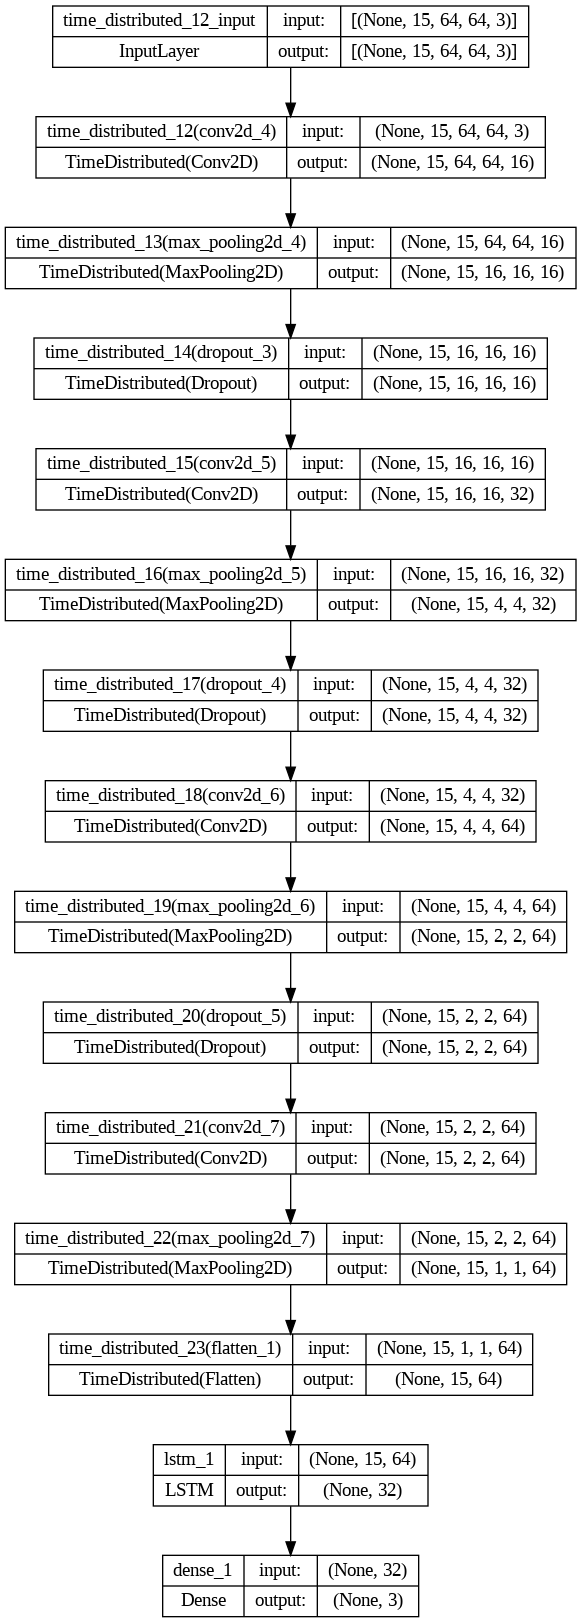

In [43]:
# Plot the structure of the contructed LRCN model.
plot_model(LRCN_model, to_file = 'LRCN_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [44]:
# Create an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=15, mode='min', restore_best_weights=True)

# Compile the model and specify loss function, optimizer, and metrics to the model.
LRCN_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=["accuracy"])

# Start training the model using the balanced dataset.
LRCN_model_training_history = LRCN_model.fit(x=balanced_features_train, y=balanced_labels_train, epochs=70, batch_size=4,
                                             shuffle=True, validation_split=0.2, callbacks=[early_stopping_callback])

Epoch 1/70
180/180 [==============================] - 8s 12ms/step - loss: 1.0762 - accuracy: 0.3819 - val_loss: 0.9164 - val_accuracy: 0.5722
Epoch 2/70
180/180 [==============================] - 1s 7ms/step - loss: 0.8059 - accuracy: 0.6292 - val_loss: 0.8861 - val_accuracy: 0.5833
Epoch 3/70
180/180 [==============================] - 1s 7ms/step - loss: 0.6794 - accuracy: 0.6958 - val_loss: 0.6742 - val_accuracy: 0.6778
Epoch 4/70
180/180 [==============================] - 1s 7ms/step - loss: 0.5855 - accuracy: 0.7542 - val_loss: 0.6215 - val_accuracy: 0.7000
Epoch 5/70
180/180 [==============================] - 1s 8ms/step - loss: 0.5469 - accuracy: 0.7694 - val_loss: 0.5396 - val_accuracy: 0.7667
Epoch 6/70
180/180 [==============================] - 1s 8ms/step - loss: 0.5041 - accuracy: 0.7861 - val_loss: 0.5387 - val_accuracy: 0.7444
Epoch 7/70
180/180 [==============================] - 1s 7ms/step - loss: 0.4461 - accuracy: 0.8264 - val_loss: 0.5561 - val_accuracy: 0.7500
Epoch

In [45]:
# Evaluate the model on the test set
test_loss, test_accuracy = LRCN_model.evaluate(features_test, labels_test)

# Print the results
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

17/17 [==============================] - 1s 28ms/step - loss: 0.6893 - accuracy: 0.6648
Test Loss: 0.6893066167831421
Test Accuracy: 0.6648044586181641


Using Cross Validation Method

In [87]:
def augment_sequence(sequence):
    # Apply horizontal flip to each frame in the sequence
    return [cv2.flip(frame, 1) for frame in sequence]

In [88]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''

    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    plt.title(str(plot_name))
    plt.legend()

In [89]:
import numpy as np
import random
import itertools
from keras.models import Sequential
from keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Dropout, Flatten, LSTM, Dense
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

def create_LRCN_model(conv_filters, lstm_units, dropout_rate, learning_rate):
    model = Sequential()
    input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)

    # First Conv2D layer with MaxPooling (4, 4)
    model.add(TimeDistributed(Conv2D(conv_filters[0], (3, 3), padding='same', activation='relu'), input_shape=input_shape))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(dropout_rate)))

    spatial_dims = [IMAGE_HEIGHT // 4, IMAGE_WIDTH // 4]  # after the first max-pooling

    # Subsequent Conv2D layers
    for idx, filters in enumerate(conv_filters[1:], start=1):
        model.add(TimeDistributed(Conv2D(filters, (3, 3), padding='same', activation='relu')))

        # Check if the spatial dimensions can be reduced further
        if spatial_dims[0] > 1 and spatial_dims[1] > 1:
            pool_size = (4, 4) if idx < 2 else (2, 2)
            model.add(TimeDistributed(MaxPooling2D(pool_size)))
            # Update the spatial dimensions after max-pooling
            spatial_dims = [dim // pool_size[0] for dim in spatial_dims]

        model.add(TimeDistributed(Dropout(dropout_rate)))

    model.add(TimeDistributed(Flatten()))

    # LSTM layer
    model.add(LSTM(lstm_units))

    # Output layer
    model.add(Dense(len(CLASSES_LIST), activation='softmax'))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=["accuracy"])
    model.summary()
    return model

In [90]:
def balance_dataset(features, labels, class_limit=300):
    decoded_labels = np.argmax(labels, axis=1)
    class_sequences = [[] for _ in range(len(CLASSES_LIST))]

    # Separate features by class
    for i, label in enumerate(decoded_labels):
        class_sequences[label].append(features[i])

    # Balancing logic
    for class_index, sequences in enumerate(class_sequences):
        if len(sequences) > class_limit:
            class_sequences[class_index] = random.sample(sequences, class_limit)
        while len(class_sequences[class_index]) < class_limit:
            sequence_to_augment = random.choice(sequences)
            class_sequences[class_index].append(augment_sequence(sequence_to_augment))

    # Combine and shuffle the balanced dataset
    balanced_features = np.concatenate(class_sequences)
    balanced_labels = np.concatenate([[to_categorical(i, num_classes=len(CLASSES_LIST)) for _ in range(class_limit)] for i in range(len(CLASSES_LIST))])

    combined = list(zip(balanced_features, balanced_labels))
    random.shuffle(combined)
    balanced_features, balanced_labels = zip(*combined)
    return np.array(balanced_features), np.array(balanced_labels)

In [72]:
# Define the hyperparameter grid
hyperparameter_grid = {
    'conv_filters': [(16, 32, 64, 64), (32, 64, 128, 128)],
    'lstm_units': [32, 64],
    'dropout_rate': [0.25],  # Fixed dropout rate
    'learning_rate': [0.001, 0.0001]
}

def get_all_hyperparameter_combinations(hyperparameter_grid):
    keys, values = zip(*hyperparameter_grid.items())
    combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]
    random.shuffle(combinations)  # Shuffle the combinations
    return combinations

In [91]:
features, labels, video_files_paths = create_dataset(video_timestamps)
one_hot_encoded_labels = to_categorical(labels, num_classes=len(CLASSES_LIST))

Extracting and classifying frames from: /content/drive/MyDrive/videos/10-Moving arms.mp4
Extracting and classifying frames from: /content/drive/MyDrive/videos/11-Moving arms.mp4
Extracting and classifying frames from: /content/drive/MyDrive/videos/12-Moving arms.mp4
Extracting and classifying frames from: /content/drive/MyDrive/videos/16-Shaking.mp4
Extracting and classifying frames from: /content/drive/MyDrive/videos/17-Shaking.mp4
Extracting and classifying frames from: /content/drive/MyDrive/videos/1_Moving arms.mp4
Extracting and classifying frames from: /content/drive/MyDrive/videos/20-Moving arms.mp4
Extracting and classifying frames from: /content/drive/MyDrive/videos/21-Moving arms.mp4
Extracting and classifying frames from: /content/drive/MyDrive/videos/23-Moving arms.mp4
Extracting and classifying frames from: /content/drive/MyDrive/videos/24-Shaking.mp4
Extracting and classifying frames from: /content/drive/MyDrive/videos/25-Moving arms.mp4
Extracting and classifying frames 

Extracting and classifying frames from: /content/drive/MyDrive/videos/10-Moving arms.mp4
Extracting and classifying frames from: /content/drive/MyDrive/videos/11-Moving arms.mp4
Extracting and classifying frames from: /content/drive/MyDrive/videos/12-Moving arms.mp4
Extracting and classifying frames from: /content/drive/MyDrive/videos/16-Shaking.mp4
Extracting and classifying frames from: /content/drive/MyDrive/videos/17-Shaking.mp4
Extracting and classifying frames from: /content/drive/MyDrive/videos/1_Moving arms.mp4
Extracting and classifying frames from: /content/drive/MyDrive/videos/20-Moving arms.mp4
Extracting and classifying frames from: /content/drive/MyDrive/videos/21-Moving arms.mp4
Extracting and classifying frames from: /content/drive/MyDrive/videos/23-Moving arms.mp4
Extracting and classifying frames from: /content/drive/MyDrive/videos/24-Shaking.mp4
Extracting and classifying frames from: /content/drive/MyDrive/videos/25-Moving arms.mp4
Extracting and classifying frames 

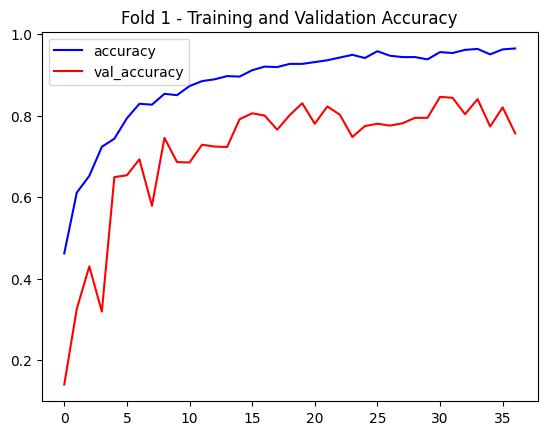

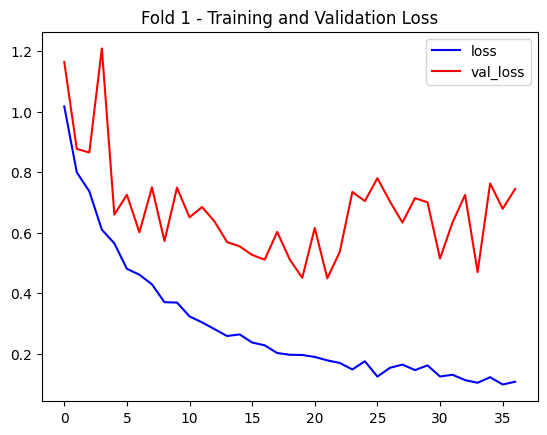

Processing fold 2
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_26 (TimeD  (None, 15, 64, 64, 16)    448       
 istributed)                                                     
                                                                 
 time_distributed_27 (TimeD  (None, 15, 16, 16, 16)    0         
 istributed)                                                     
                                                                 
 time_distributed_28 (TimeD  (None, 15, 16, 16, 16)    0         
 istributed)                                                     
                                                                 
 time_distributed_29 (TimeD  (None, 15, 16, 16, 32)    4640      
 istributed)                                                     
                                                                 
 time_distributed_30 (TimeD  (None, 

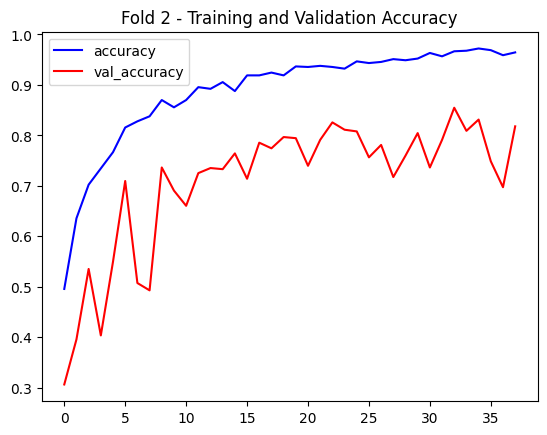

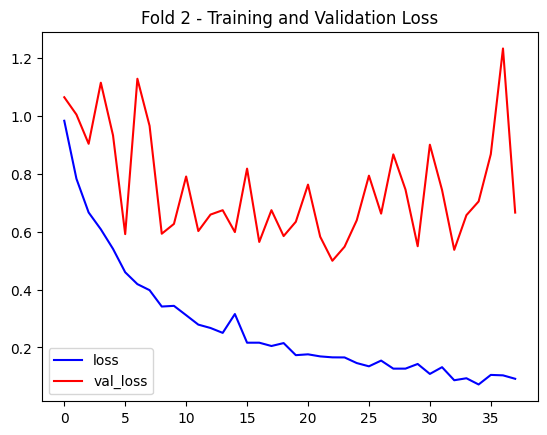

Processing fold 3
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_39 (TimeD  (None, 15, 64, 64, 16)    448       
 istributed)                                                     
                                                                 
 time_distributed_40 (TimeD  (None, 15, 16, 16, 16)    0         
 istributed)                                                     
                                                                 
 time_distributed_41 (TimeD  (None, 15, 16, 16, 16)    0         
 istributed)                                                     
                                                                 
 time_distributed_42 (TimeD  (None, 15, 16, 16, 32)    4640      
 istributed)                                                     
                                                                 
 time_distributed_43 (TimeD  (None, 

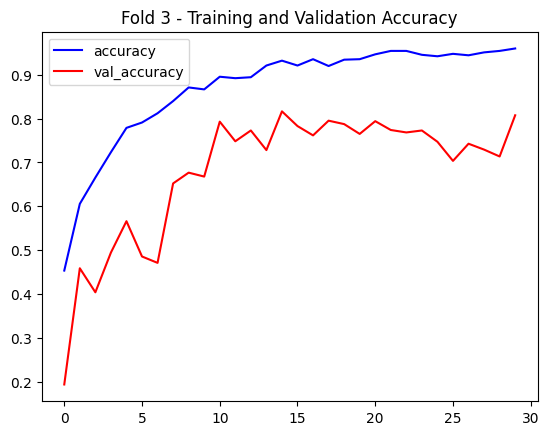

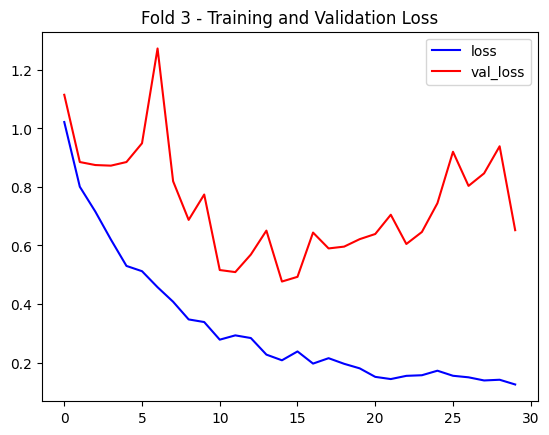

Current Hyperparameters: {'conv_filters': (16, 32, 64, 64), 'lstm_units': 32, 'dropout_rate': 0.25, 'learning_rate': 0.0001}
Processing fold 1
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_52 (TimeD  (None, 15, 64, 64, 16)    448       
 istributed)                                                     
                                                                 
 time_distributed_53 (TimeD  (None, 15, 16, 16, 16)    0         
 istributed)                                                     
                                                                 
 time_distributed_54 (TimeD  (None, 15, 16, 16, 16)    0         
 istributed)                                                     
                                                                 
 time_distributed_55 (TimeD  (None, 15, 16, 16, 32)    4640      
 istributed)                               

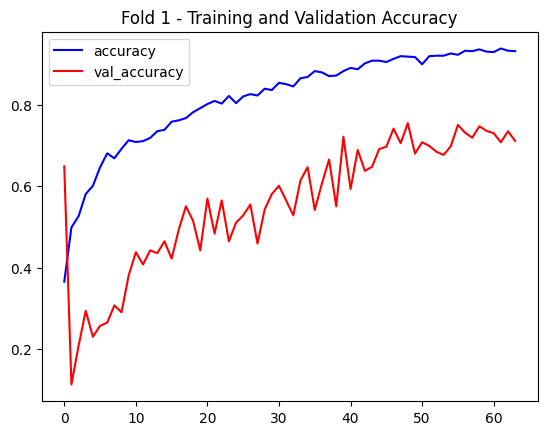

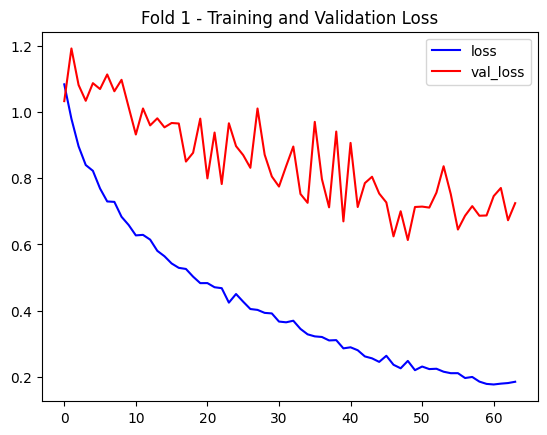

Processing fold 2
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_65 (TimeD  (None, 15, 64, 64, 16)    448       
 istributed)                                                     
                                                                 
 time_distributed_66 (TimeD  (None, 15, 16, 16, 16)    0         
 istributed)                                                     
                                                                 
 time_distributed_67 (TimeD  (None, 15, 16, 16, 16)    0         
 istributed)                                                     
                                                                 
 time_distributed_68 (TimeD  (None, 15, 16, 16, 32)    4640      
 istributed)                                                     
                                                                 
 time_distributed_69 (TimeD  (None, 

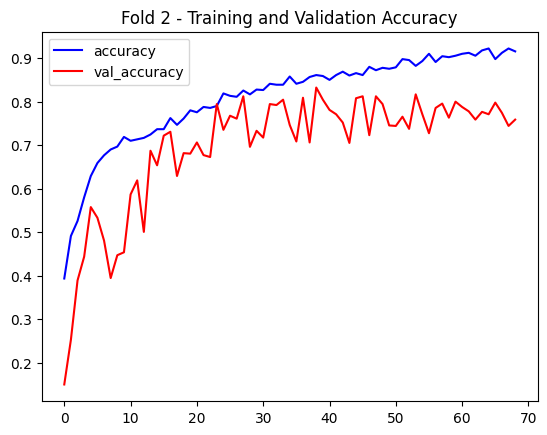

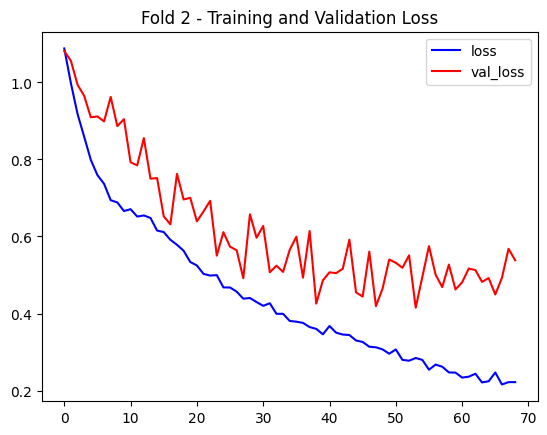

Processing fold 3
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_78 (TimeD  (None, 15, 64, 64, 16)    448       
 istributed)                                                     
                                                                 
 time_distributed_79 (TimeD  (None, 15, 16, 16, 16)    0         
 istributed)                                                     
                                                                 
 time_distributed_80 (TimeD  (None, 15, 16, 16, 16)    0         
 istributed)                                                     
                                                                 
 time_distributed_81 (TimeD  (None, 15, 16, 16, 32)    4640      
 istributed)                                                     
                                                                 
 time_distributed_82 (TimeD  (None, 

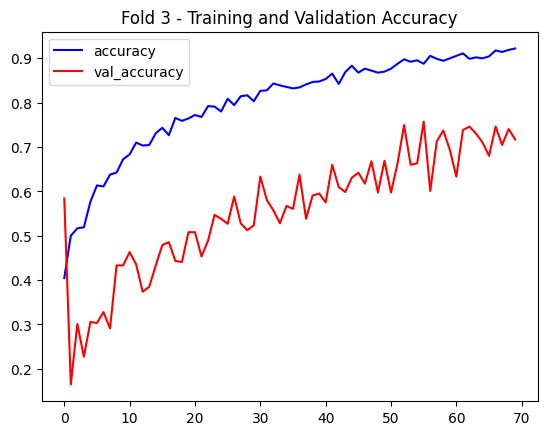

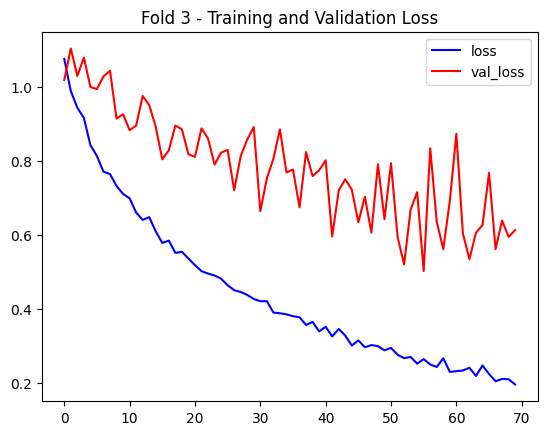

Current Hyperparameters: {'conv_filters': (32, 64, 128, 128), 'lstm_units': 32, 'dropout_rate': 0.25, 'learning_rate': 0.0001}
Processing fold 1
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_91 (TimeD  (None, 15, 64, 64, 32)    896       
 istributed)                                                     
                                                                 
 time_distributed_92 (TimeD  (None, 15, 16, 16, 32)    0         
 istributed)                                                     
                                                                 
 time_distributed_93 (TimeD  (None, 15, 16, 16, 32)    0         
 istributed)                                                     
                                                                 
 time_distributed_94 (TimeD  (None, 15, 16, 16, 64)    18496     
 istributed)                             

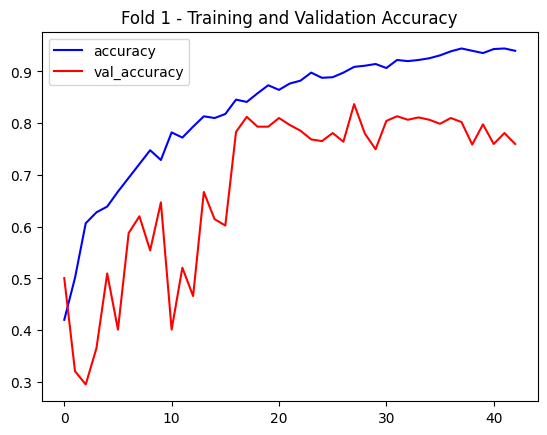

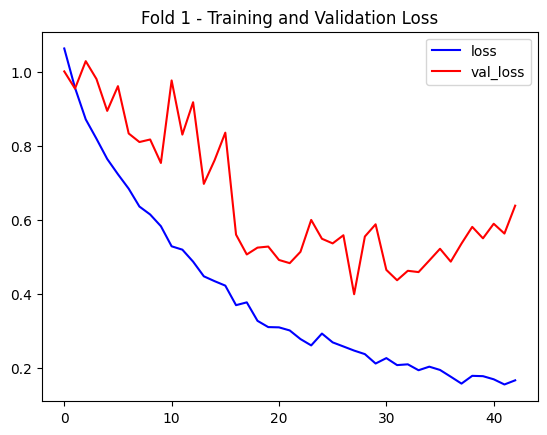

Processing fold 2
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_104 (Time  (None, 15, 64, 64, 32)    896       
 Distributed)                                                    
                                                                 
 time_distributed_105 (Time  (None, 15, 16, 16, 32)    0         
 Distributed)                                                    
                                                                 
 time_distributed_106 (Time  (None, 15, 16, 16, 32)    0         
 Distributed)                                                    
                                                                 
 time_distributed_107 (Time  (None, 15, 16, 16, 64)    18496     
 Distributed)                                                    
                                                                 
 time_distributed_108 (Time  (None, 

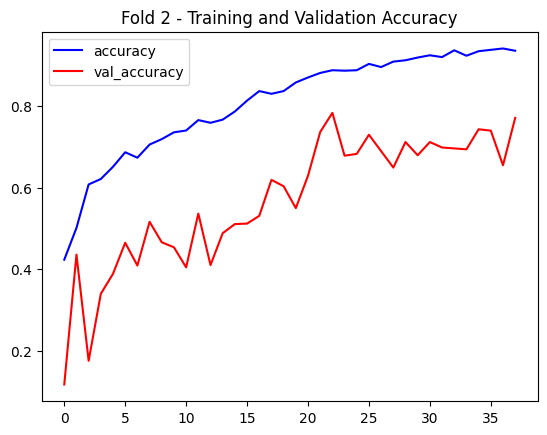

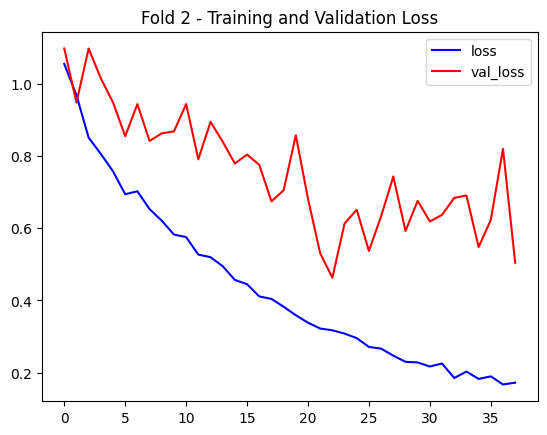

Processing fold 3
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_117 (Time  (None, 15, 64, 64, 32)    896       
 Distributed)                                                    
                                                                 
 time_distributed_118 (Time  (None, 15, 16, 16, 32)    0         
 Distributed)                                                    
                                                                 
 time_distributed_119 (Time  (None, 15, 16, 16, 32)    0         
 Distributed)                                                    
                                                                 
 time_distributed_120 (Time  (None, 15, 16, 16, 64)    18496     
 Distributed)                                                    
                                                                 
 time_distributed_121 (Time  (None, 

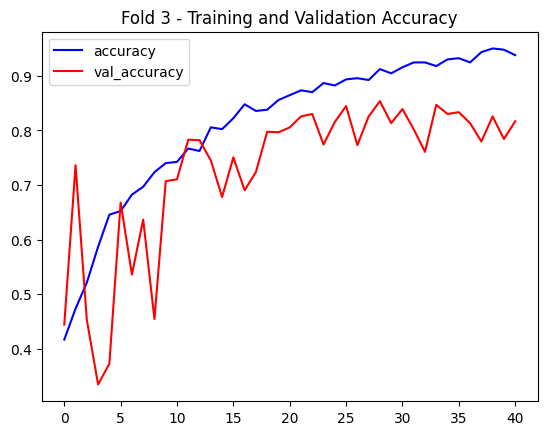

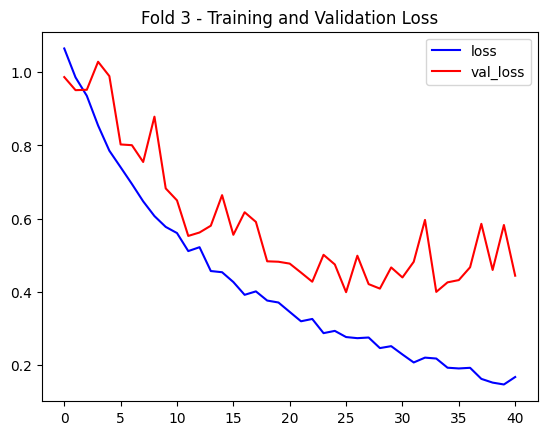

Current Hyperparameters: {'conv_filters': (32, 64, 128, 128), 'lstm_units': 64, 'dropout_rate': 0.25, 'learning_rate': 0.001}
Processing fold 1
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_130 (Time  (None, 15, 64, 64, 32)    896       
 Distributed)                                                    
                                                                 
 time_distributed_131 (Time  (None, 15, 16, 16, 32)    0         
 Distributed)                                                    
                                                                 
 time_distributed_132 (Time  (None, 15, 16, 16, 32)    0         
 Distributed)                                                    
                                                                 
 time_distributed_133 (Time  (None, 15, 16, 16, 64)    18496     
 Distributed)                            

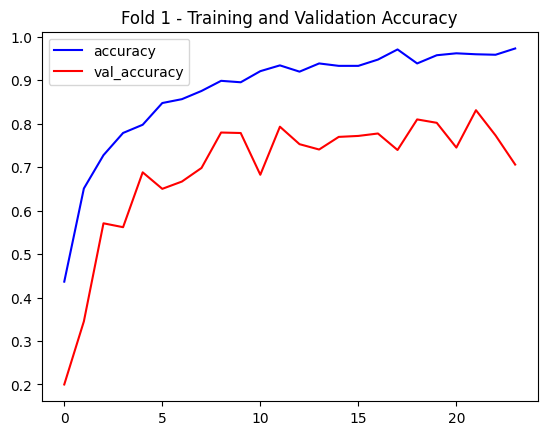

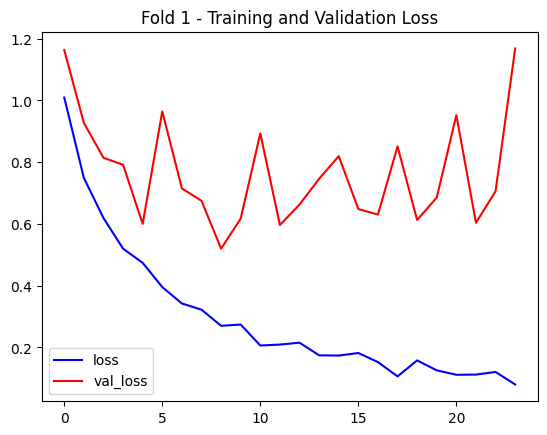

Processing fold 2
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_143 (Time  (None, 15, 64, 64, 32)    896       
 Distributed)                                                    
                                                                 
 time_distributed_144 (Time  (None, 15, 16, 16, 32)    0         
 Distributed)                                                    
                                                                 
 time_distributed_145 (Time  (None, 15, 16, 16, 32)    0         
 Distributed)                                                    
                                                                 
 time_distributed_146 (Time  (None, 15, 16, 16, 64)    18496     
 Distributed)                                                    
                                                                 
 time_distributed_147 (Time  (None,

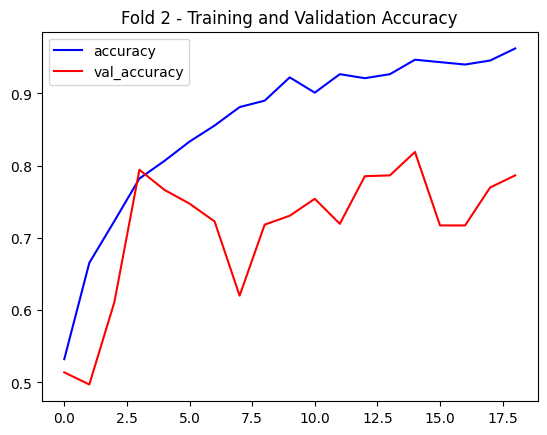

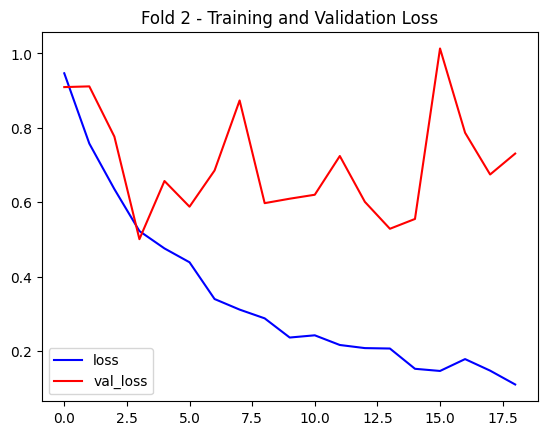

Processing fold 3
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_156 (Time  (None, 15, 64, 64, 32)    896       
 Distributed)                                                    
                                                                 
 time_distributed_157 (Time  (None, 15, 16, 16, 32)    0         
 Distributed)                                                    
                                                                 
 time_distributed_158 (Time  (None, 15, 16, 16, 32)    0         
 Distributed)                                                    
                                                                 
 time_distributed_159 (Time  (None, 15, 16, 16, 64)    18496     
 Distributed)                                                    
                                                                 
 time_distributed_160 (Time  (None,

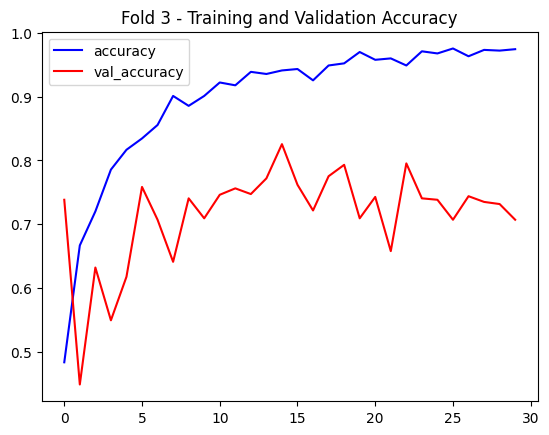

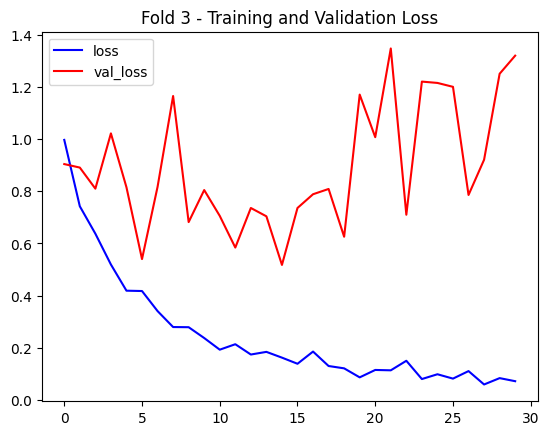

Current Hyperparameters: {'conv_filters': (32, 64, 128, 128), 'lstm_units': 32, 'dropout_rate': 0.25, 'learning_rate': 0.001}
Processing fold 1
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_169 (Time  (None, 15, 64, 64, 32)    896       
 Distributed)                                                    
                                                                 
 time_distributed_170 (Time  (None, 15, 16, 16, 32)    0         
 Distributed)                                                    
                                                                 
 time_distributed_171 (Time  (None, 15, 16, 16, 32)    0         
 Distributed)                                                    
                                                                 
 time_distributed_172 (Time  (None, 15, 16, 16, 64)    18496     
 Distributed)                            

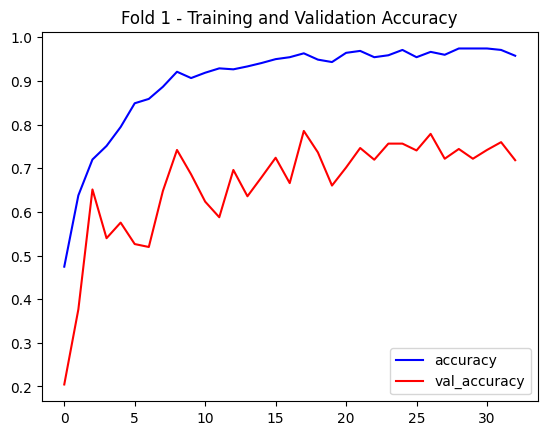

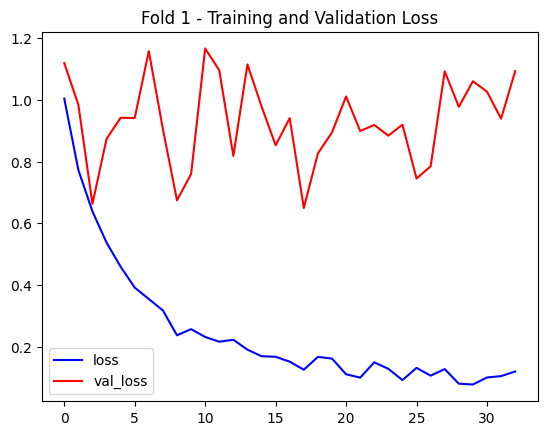

Processing fold 2
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_182 (Time  (None, 15, 64, 64, 32)    896       
 Distributed)                                                    
                                                                 
 time_distributed_183 (Time  (None, 15, 16, 16, 32)    0         
 Distributed)                                                    
                                                                 
 time_distributed_184 (Time  (None, 15, 16, 16, 32)    0         
 Distributed)                                                    
                                                                 
 time_distributed_185 (Time  (None, 15, 16, 16, 64)    18496     
 Distributed)                                                    
                                                                 
 time_distributed_186 (Time  (None,

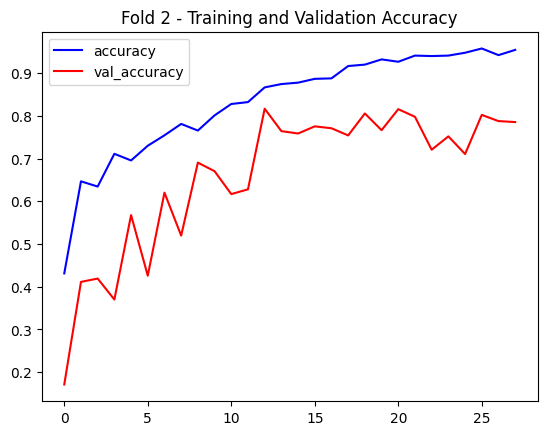

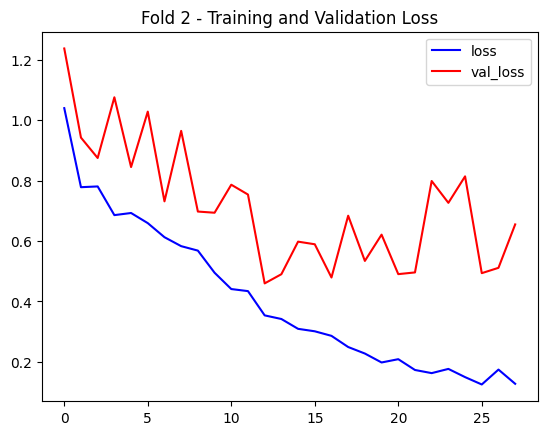

Processing fold 3
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_195 (Time  (None, 15, 64, 64, 32)    896       
 Distributed)                                                    
                                                                 
 time_distributed_196 (Time  (None, 15, 16, 16, 32)    0         
 Distributed)                                                    
                                                                 
 time_distributed_197 (Time  (None, 15, 16, 16, 32)    0         
 Distributed)                                                    
                                                                 
 time_distributed_198 (Time  (None, 15, 16, 16, 64)    18496     
 Distributed)                                                    
                                                                 
 time_distributed_199 (Time  (None,

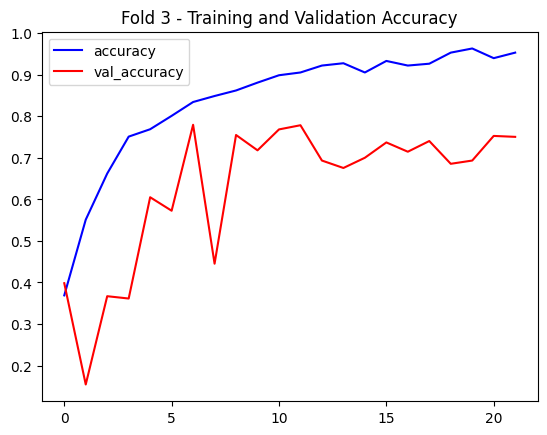

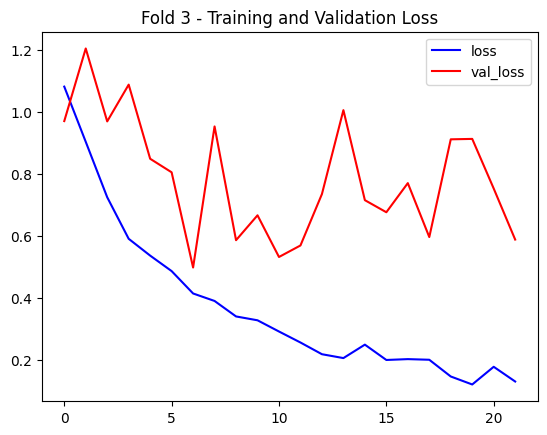

Current Hyperparameters: {'conv_filters': (32, 64, 128, 128), 'lstm_units': 64, 'dropout_rate': 0.25, 'learning_rate': 0.0001}
Processing fold 1
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_208 (Time  (None, 15, 64, 64, 32)    896       
 Distributed)                                                    
                                                                 
 time_distributed_209 (Time  (None, 15, 16, 16, 32)    0         
 Distributed)                                                    
                                                                 
 time_distributed_210 (Time  (None, 15, 16, 16, 32)    0         
 Distributed)                                                    
                                                                 
 time_distributed_211 (Time  (None, 15, 16, 16, 64)    18496     
 Distributed)                           

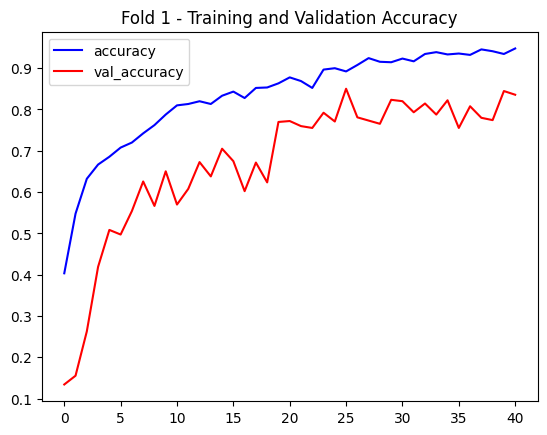

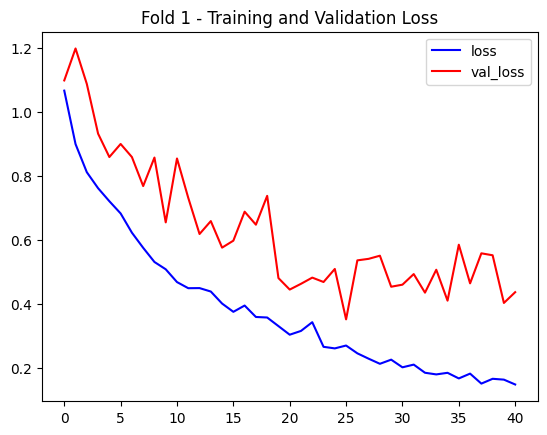

Processing fold 2
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_221 (Time  (None, 15, 64, 64, 32)    896       
 Distributed)                                                    
                                                                 
 time_distributed_222 (Time  (None, 15, 16, 16, 32)    0         
 Distributed)                                                    
                                                                 
 time_distributed_223 (Time  (None, 15, 16, 16, 32)    0         
 Distributed)                                                    
                                                                 
 time_distributed_224 (Time  (None, 15, 16, 16, 64)    18496     
 Distributed)                                                    
                                                                 
 time_distributed_225 (Time  (None,

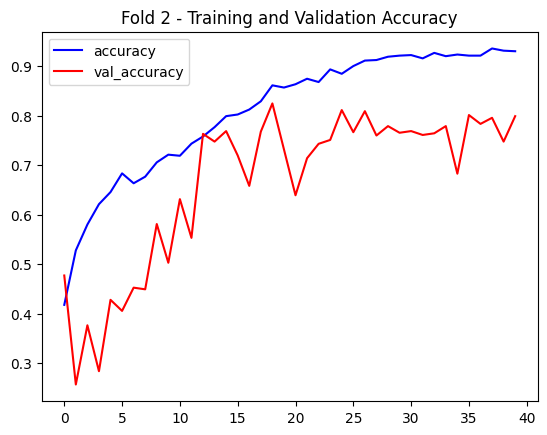

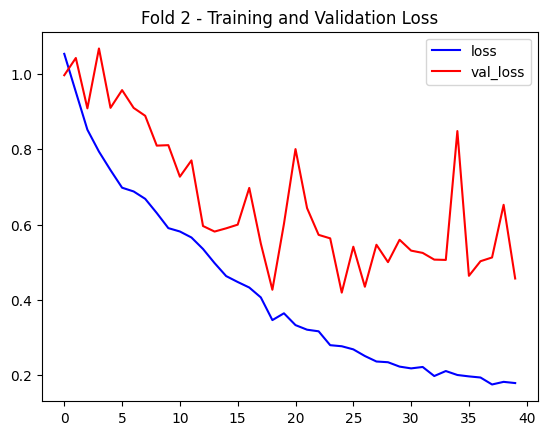

Processing fold 3
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_234 (Time  (None, 15, 64, 64, 32)    896       
 Distributed)                                                    
                                                                 
 time_distributed_235 (Time  (None, 15, 16, 16, 32)    0         
 Distributed)                                                    
                                                                 
 time_distributed_236 (Time  (None, 15, 16, 16, 32)    0         
 Distributed)                                                    
                                                                 
 time_distributed_237 (Time  (None, 15, 16, 16, 64)    18496     
 Distributed)                                                    
                                                                 
 time_distributed_238 (Time  (None,

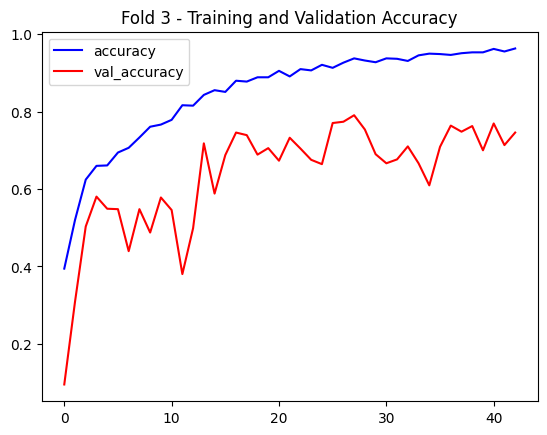

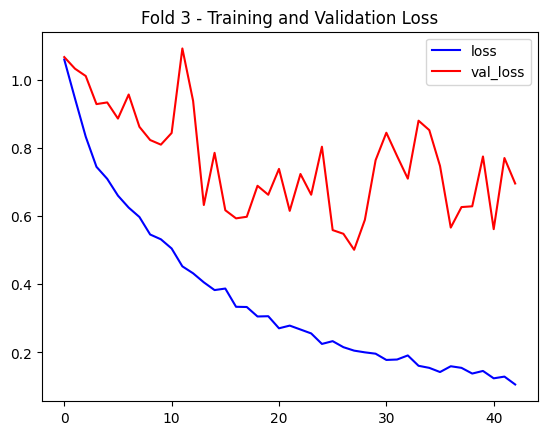

Current Hyperparameters: {'conv_filters': (16, 32, 64, 64), 'lstm_units': 64, 'dropout_rate': 0.25, 'learning_rate': 0.001}
Processing fold 1
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_247 (Time  (None, 15, 64, 64, 16)    448       
 Distributed)                                                    
                                                                 
 time_distributed_248 (Time  (None, 15, 16, 16, 16)    0         
 Distributed)                                                    
                                                                 
 time_distributed_249 (Time  (None, 15, 16, 16, 16)    0         
 Distributed)                                                    
                                                                 
 time_distributed_250 (Time  (None, 15, 16, 16, 32)    4640      
 Distributed)                              

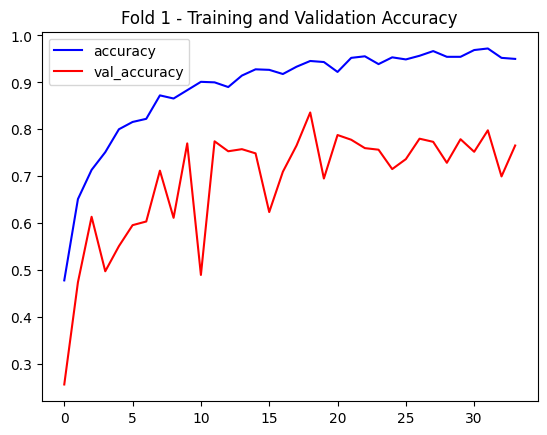

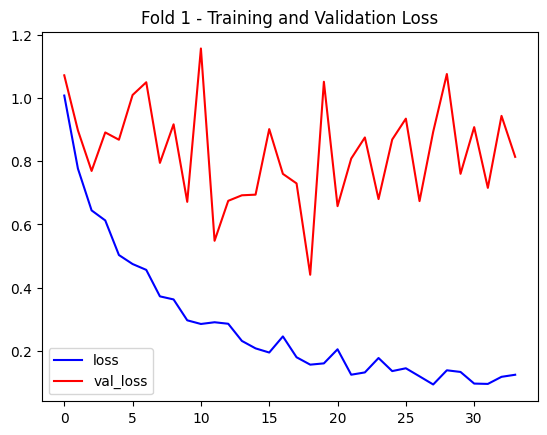

Processing fold 2
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_260 (Time  (None, 15, 64, 64, 16)    448       
 Distributed)                                                    
                                                                 
 time_distributed_261 (Time  (None, 15, 16, 16, 16)    0         
 Distributed)                                                    
                                                                 
 time_distributed_262 (Time  (None, 15, 16, 16, 16)    0         
 Distributed)                                                    
                                                                 
 time_distributed_263 (Time  (None, 15, 16, 16, 32)    4640      
 Distributed)                                                    
                                                                 
 time_distributed_264 (Time  (None,

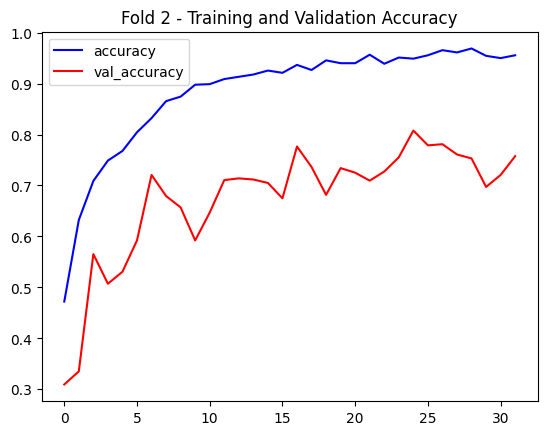

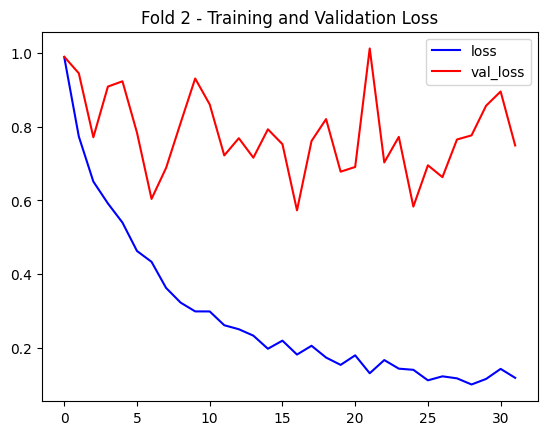

Processing fold 3
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_273 (Time  (None, 15, 64, 64, 16)    448       
 Distributed)                                                    
                                                                 
 time_distributed_274 (Time  (None, 15, 16, 16, 16)    0         
 Distributed)                                                    
                                                                 
 time_distributed_275 (Time  (None, 15, 16, 16, 16)    0         
 Distributed)                                                    
                                                                 
 time_distributed_276 (Time  (None, 15, 16, 16, 32)    4640      
 Distributed)                                                    
                                                                 
 time_distributed_277 (Time  (None,

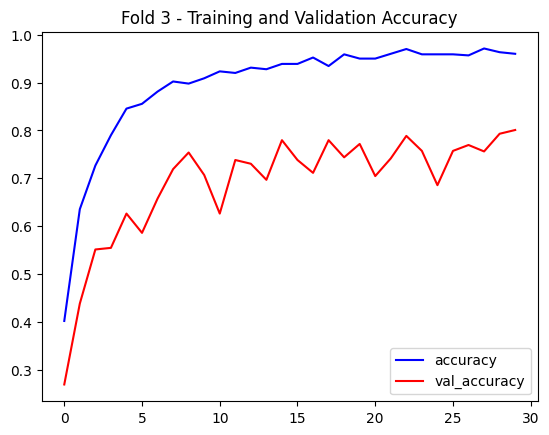

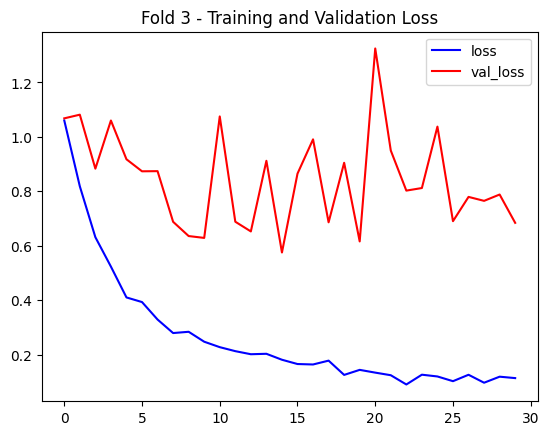

Current Hyperparameters: {'conv_filters': (16, 32, 64, 64), 'lstm_units': 64, 'dropout_rate': 0.25, 'learning_rate': 0.0001}
Processing fold 1
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_286 (Time  (None, 15, 64, 64, 16)    448       
 Distributed)                                                    
                                                                 
 time_distributed_287 (Time  (None, 15, 16, 16, 16)    0         
 Distributed)                                                    
                                                                 
 time_distributed_288 (Time  (None, 15, 16, 16, 16)    0         
 Distributed)                                                    
                                                                 
 time_distributed_289 (Time  (None, 15, 16, 16, 32)    4640      
 Distributed)                             

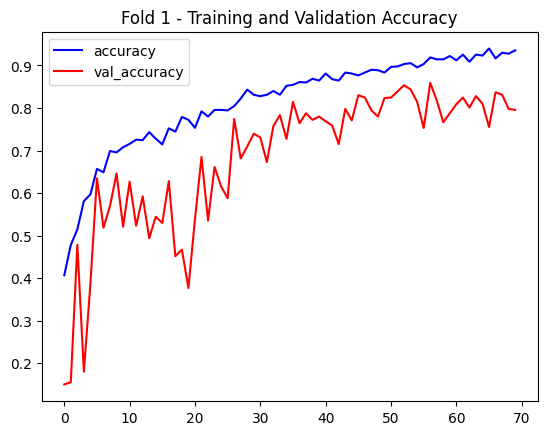

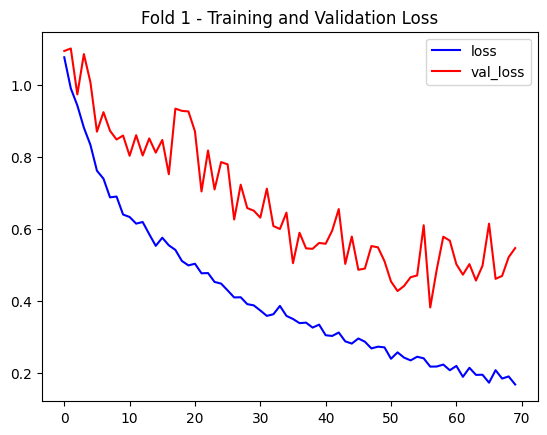

Processing fold 2
Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_299 (Time  (None, 15, 64, 64, 16)    448       
 Distributed)                                                    
                                                                 
 time_distributed_300 (Time  (None, 15, 16, 16, 16)    0         
 Distributed)                                                    
                                                                 
 time_distributed_301 (Time  (None, 15, 16, 16, 16)    0         
 Distributed)                                                    
                                                                 
 time_distributed_302 (Time  (None, 15, 16, 16, 32)    4640      
 Distributed)                                                    
                                                                 
 time_distributed_303 (Time  (None,

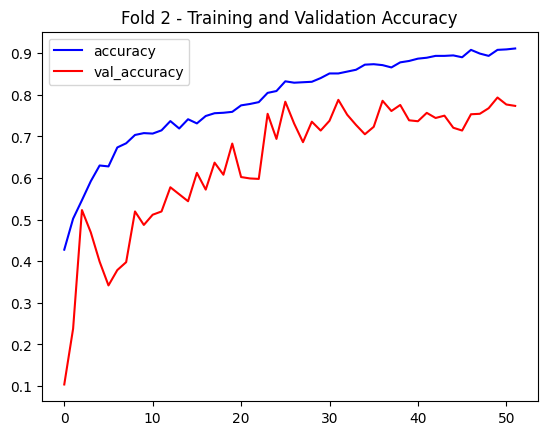

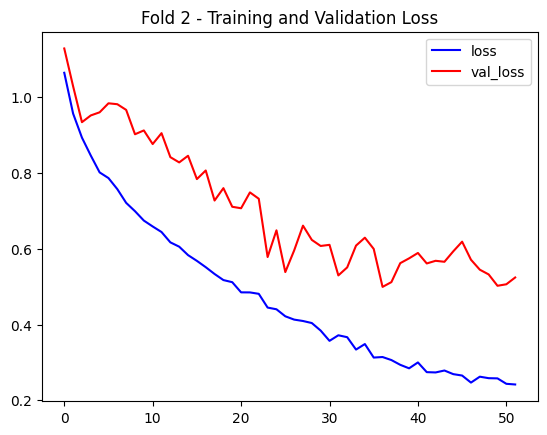

Processing fold 3
Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_312 (Time  (None, 15, 64, 64, 16)    448       
 Distributed)                                                    
                                                                 
 time_distributed_313 (Time  (None, 15, 16, 16, 16)    0         
 Distributed)                                                    
                                                                 
 time_distributed_314 (Time  (None, 15, 16, 16, 16)    0         
 Distributed)                                                    
                                                                 
 time_distributed_315 (Time  (None, 15, 16, 16, 32)    4640      
 Distributed)                                                    
                                                                 
 time_distributed_316 (Time  (None,

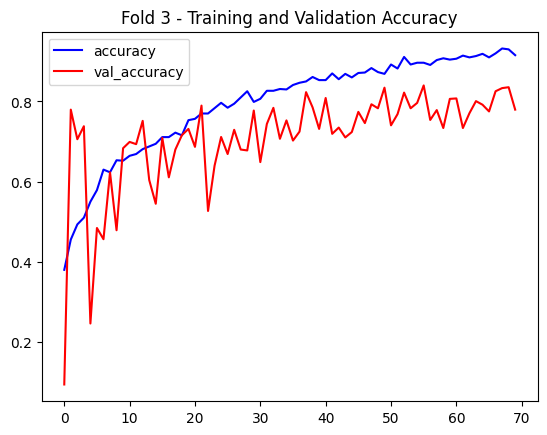

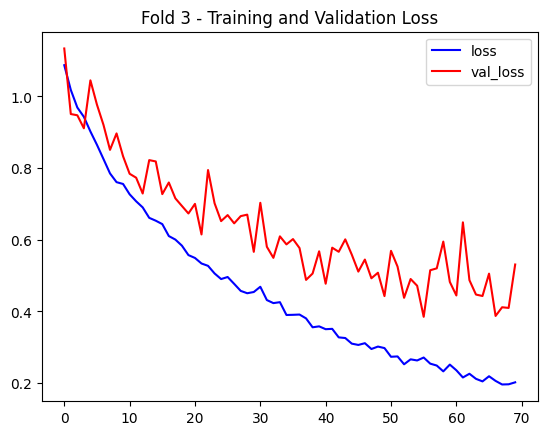

Best Hyperparameters: {'conv_filters': (32, 64, 128, 128), 'lstm_units': 32, 'dropout_rate': 0.25, 'learning_rate': 0.0001}
Best Accuracy: 0.8215435743331909


In [19]:
num_folds = 3
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

best_hyperparams = None
best_accuracy = 0

# Iterate over all combinations of hyperparameters
for hyperparams in get_all_hyperparameter_combinations(hyperparameter_grid):
  print("Current Hyperparameters:", hyperparams)
  fold_accuracies = []
  for fold, (train_index, test_index) in enumerate(kf.split(features)):
      print(f"Processing fold {fold + 1}")

      # Split data into training and testing sets for this fold
      features_train, features_test = features[train_index], features[test_index]
      labels_train, labels_test = one_hot_encoded_labels[train_index], one_hot_encoded_labels[test_index]
      true_labels_test = labels[test_index]

      # Balance the training data in this fold using the balance_dataset function
      balanced_features_train, balanced_labels_train = balance_dataset(features_train, labels_train, class_limit=300)

      # Create and compile the LRCN model
      model = create_LRCN_model(hyperparams['conv_filters'], hyperparams['lstm_units'], hyperparams['dropout_rate'], hyperparams['learning_rate'])

      # Early Stopping Callback
      early_stopping_callback = EarlyStopping(monitor='val_loss', patience=15, mode='min', restore_best_weights=True)

      # Fit the model and store the history
      history = model.fit(
          x=balanced_features_train,
          y=balanced_labels_train,
          epochs=70,
          batch_size=4,
          validation_data=(features_test, labels_test),
          callbacks=[early_stopping_callback]
      )
      # Evaluate the model on the test set of this fold and store the accuracy
      test_loss, test_accuracy = model.evaluate(features_test, labels_test)
      fold_accuracies.append(test_accuracy)

      # Plot training and validation accuracy and loss
      plot_metric(history, 'accuracy', 'val_accuracy', f'Fold {fold+1} - Training and Validation Accuracy')
      plt.show()
      plot_metric(history, 'loss', 'val_loss', f'Fold {fold+1} - Training and Validation Loss')
      plt.show()

  average_accuracy = np.mean(fold_accuracies)
  if average_accuracy > best_accuracy:
      best_accuracy = average_accuracy
      best_hyperparams = hyperparams

print("Best Hyperparameters:", best_hyperparams)
print("Best Accuracy:", best_accuracy)

In [102]:
features_train, features_test, labels_train, labels_test = train_test_split(
    features,
    one_hot_encoded_labels,
    test_size=0.2,  
    stratify=np.argmax(one_hot_encoded_labels, axis=1),  
    random_state=42
)

# Balance only the training dataset
balanced_features_train, balanced_labels_train = balance_dataset(features_train, labels_train)

# Create and compile the LRCN model with the best hyperparameters
model = create_LRCN_model(
    best_hyperparams['conv_filters'],
    best_hyperparams['lstm_units'],
    best_hyperparams['dropout_rate'],
    best_hyperparams['learning_rate']
)

# Train the model on the balanced training dataset
history = model.fit(
    x=balanced_features_train,
    y=balanced_labels_train,
    epochs=70,
    batch_size=4,
    validation_data=(features_test, labels_test),  # Use the original test set for validation
    callbacks=[EarlyStopping(monitor='val_loss', patience=15, mode='min', restore_best_weights=True)]
)

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_442 (Time  (None, 15, 64, 64, 32)    896       
 Distributed)                                                    
                                                                 
 time_distributed_443 (Time  (None, 15, 16, 16, 32)    0         
 Distributed)                                                    
                                                                 
 time_distributed_444 (Time  (None, 15, 16, 16, 32)    0         
 Distributed)                                                    
                                                                 
 time_distributed_445 (Time  (None, 15, 16, 16, 64)    18496     
 Distributed)                                                    
                                                                 
 time_distributed_446 (Time  (None, 15, 4, 4, 64)    

In [103]:
model.save('LRCN.h5')
model.save_weights('LRCN_weights.h5')

  saving_api.save_model(



In [104]:
# Evaluate the model's performance on the unbalanced test set
final_loss, final_accuracy = model.evaluate(features_test, labels_test)
print("Final Model Accuracy:", final_accuracy)

17/17 [==============================] - 0s 14ms/step - loss: 0.4034 - accuracy: 0.8547
Final Model Accuracy: 0.8547486066818237


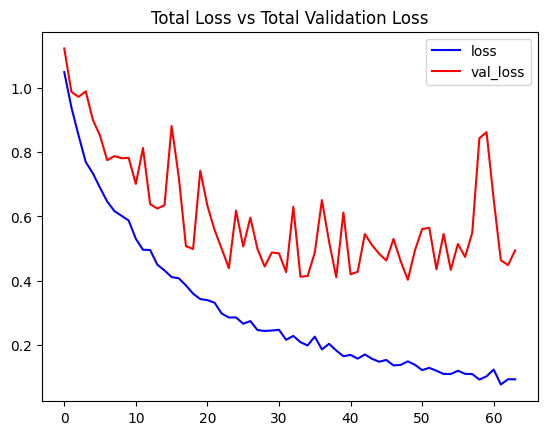

In [105]:
# Visualize the training and validation loss metrices.
plot_metric(history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

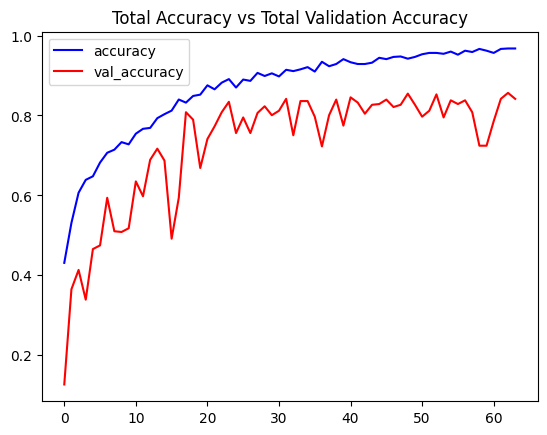

In [106]:
# Visualize the training and validation accuracy metrices.
plot_metric(history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

17/17 [==============================] - 1s 12ms/step


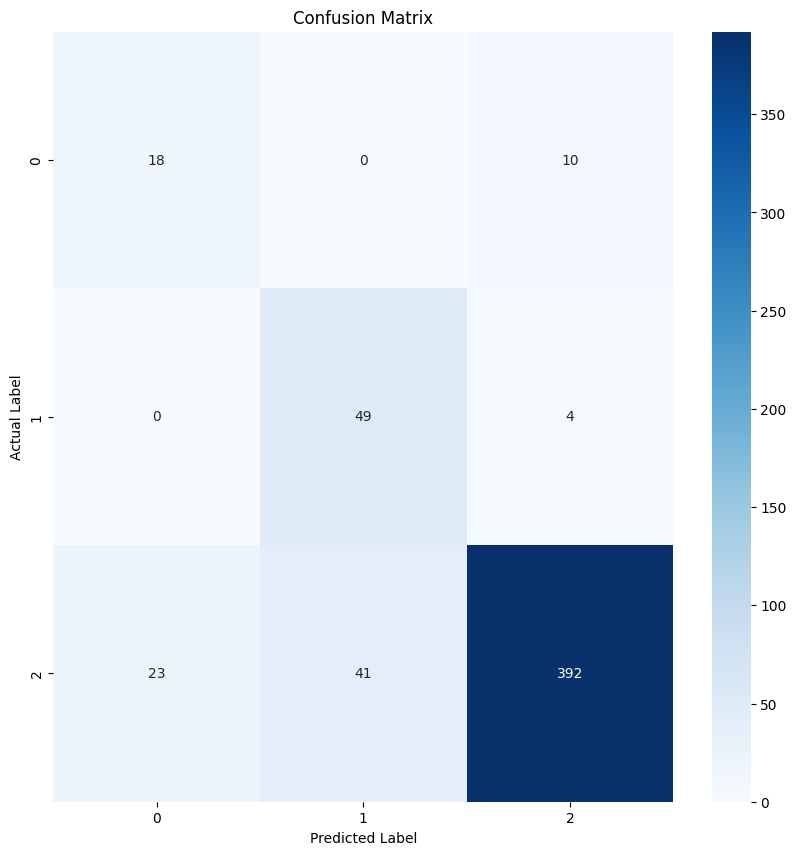

In [107]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

predicted_labels = model.predict(features_test)
predicted_labels = np.argmax(predicted_labels, axis=1) # Convert probabilities to class labels

true_labels = np.argmax(labels_test, axis=1) 
cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

In [108]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

precision, recall, f1_score, support = precision_recall_fscore_support(true_labels, predicted_labels)

accuracy = accuracy_score(true_labels, predicted_labels)

print(f"Accuracy: {accuracy:.2f}\n")
print("Class-wise evaluation metrics:")
print(f"{'Class':<15}{'Precision':<10}{'Recall':<10}{'F1-Score':<10}{'Support':<10}")
for i, class_label in enumerate(CLASSES_LIST):
    print(f"{class_label:<15}{precision[i]:<10.2f}{recall[i]:<10.2f}{f1_score[i]:<10.2f}{support[i]:<10}")

Accuracy: 0.85

Class-wise evaluation metrics:
Class          Precision Recall    F1-Score  Support   
moving_arms    0.44      0.64      0.52      28        
hand_shaking   0.54      0.92      0.69      53        
nothing        0.97      0.86      0.91      456       
